In [1]:
import matplotlib.pyplot as plt
plt.rcParams["figure.autolayout"] = True # to for tight_layout()
import pymc as pm
import pytensor as pt
import numpy as np
import pandas as pd
import itertools
import random
import operator
import arviz as az

In [2]:
#32 Haplotypes
#5 placings in the haplotype (2⁵ = 32)
#100 genotypes

haplotypes = list(map(list, itertools.product([0, 1], repeat=5)))
haplotypesProb = [
    0.0056,   0.004,                0.00368,  0.1,                 
    0.005681, 0.09,                 0.00468,  0.003,    
    0.08,     0.006147,             0.00595,  0.0071,   
    0.00345,  0.00632,              0.1,      0.0029,   
    0.0071,   0.006147,             0.085,    0.0045671,
    0.003379, 0.1,                  0.00461,  0.00614,             
    0.075,    0.08,                 0.00761,  0.004321, 
    0.09,     0.009217900000000112, 0.0134,   0.075]

haplotypes_prob_synth = [
    0.00100000000000000, 0.00100000000000000, 0.00100000000000000, 0.00100000000000000,
    0.00100000000000000, 0.32366666666666666, 0.00100000000000000, 0.00100000000000000,
    0.00100000000000000, 0.00100000000000000, 0.00100000000000000, 0.00100000000000000,   
    0.00100000000000000, 0.00100000000000000, 0.00100000000000000, 0.00100000000000000,
    0.00100000000000000, 0.00100000000000000, 0.32366666666666666, 0.00100000000000000,
    0.00100000000000000, 0.00100000000000000, 0.00100000000000000, 0.00100000000000000,
    0.00100000000000000, 0.00100000000000000, 0.00100000000000000, 0.00100000000000000,
    0.00100000000000000, 0.00100000000000000, 0.00100000000000000, 0.32366666666666666
]

haplotypesProb=haplotypes_prob_synth

# NOTE: This is a dict to store the number of haplotypes drawn from the probabilities above
haplotypesnumber = {}
for i in range(32):
    haplotypesnumber[str(haplotypes[i])] = 0

# NOTE: This code snippet samples 100 genotypes by sampling haplotypes with the probabilities above
#       I suppose the goal is to recover the probabilities above
genotypes = []
d = {'h_1': [], 'h_2': [], 'g': []} # NOTE: added by Raúl
# seeds not working...
np.random.seed(2023)
random.seed(2023)
for i in range(100):
    h1 = np.random.choice(np.arange(32), p=haplotypesProb) # samples one haplotype (from 0 to 31) with probabilities above
    h2 = np.random.choice(np.arange(32), p=haplotypesProb) # samples one haplotype (from 0 to 31) with probabilities above
    genotypes.append(list(map(operator.add,haplotypes[h1],haplotypes[h2]))) # combines them to form a genotype
    d['h_1'].append(haplotypes[h1]); d['h_2'].append(haplotypes[h2]); d['g'].append(genotypes[i]); # NOTE: added by Raúl
    haplotypesnumber[str(haplotypes[h1])] = haplotypesnumber[str(haplotypes[h1])] +1 # keeps count of sampled haplotypes 
    haplotypesnumber[str(haplotypes[h2])] = haplotypesnumber[str(haplotypes[h2])] +1 # keeps count of sampled haplotypes 
df = pd.DataFrame(data=d)

In [3]:
with pm.Model() as model_dirac:
    num_vars = 5*100*2
    x = pm.DiscreteUniform('x',0, 1,shape=num_vars)

    for i in range(100): # iterate over all genotypes
        for j in range(5): # iterate over all bits of the BitVec
            pm.DiracDelta(f'c_{(i,j)}', x[i*10+j] + x[i*10+j+5], observed=genotypes[i][j])

In [4]:
# init state
init_state = [
    0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0,
    1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1,
    0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1,
    0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1,
    1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1,
    0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0,
    0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1,
    1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0,
    1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0,
    0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1,
    1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1,
    0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0,
    1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
    0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1,
    0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1,
    0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
    1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1,
    1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0,
    0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1,
    0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
    0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1,
    1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
    1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0,
    1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1,
    0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1,
    1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1,
    1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
    1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0,
    0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0,
    0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
    1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
    1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1,
    0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1,
    1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0,
    1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0,
    1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
    1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0,
    1, 1, 1, 1, 1, 1, 0, 0, 1, 0]


# sampling
with model_dirac:
    # covariance matrix of proposal dist (MultivariateNormal)
    S = np.zeros((num_vars,num_vars), np.int64)
    np.fill_diagonal(S,100)

    # config metropolis
    step = pm.Metropolis(
        S=S, # set new proposal dist
        tune_interval=1000 # incrase steps between samples?
    )

    trace = pm.sample(
        draws=100,
        tune=20, # a lot of tunning steps
        cores=4, # 4 chains, produced in 4 different cores
        initvals={'x': init_state} # we must a satisfying initial state, otherwise it does not work...
    ) 

/home/pardo/programs/miniconda3/envs/prpro-2024/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:1029: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Only 100 samples in chain.
/home/pardo/programs/miniconda3/envs/prpro-2024/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:1029: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [x]


Sampling 4 chains for 20 tune and 100 draw iterations (80 + 400 draws total) took 4130 seconds.
/home/pardo/programs/miniconda3/envs/prpro-2024/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


In [6]:
# ti took 4130 seconds to (plus ~4min to compile the model)
az.to_netcdf(trace,'haplotypes_PyMC_200_2.nc')

'haplotypes_PyMC_200_2.nc'

In [33]:
[(np.unique(trace.posterior.x,axis=1).reshape(4,1000)[i] == np.unique(trace.posterior.x,axis=1).reshape(4,1000)[i+1]).prod() for i in range(3)]

[1, 1, 1]

/home/pardo/programs/miniconda3/envs/prpro-2024/lib/python3.11/site-packages/arviz/plots/traceplot.py:222: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (1000), generating only 20 plots
  warnings.warn(


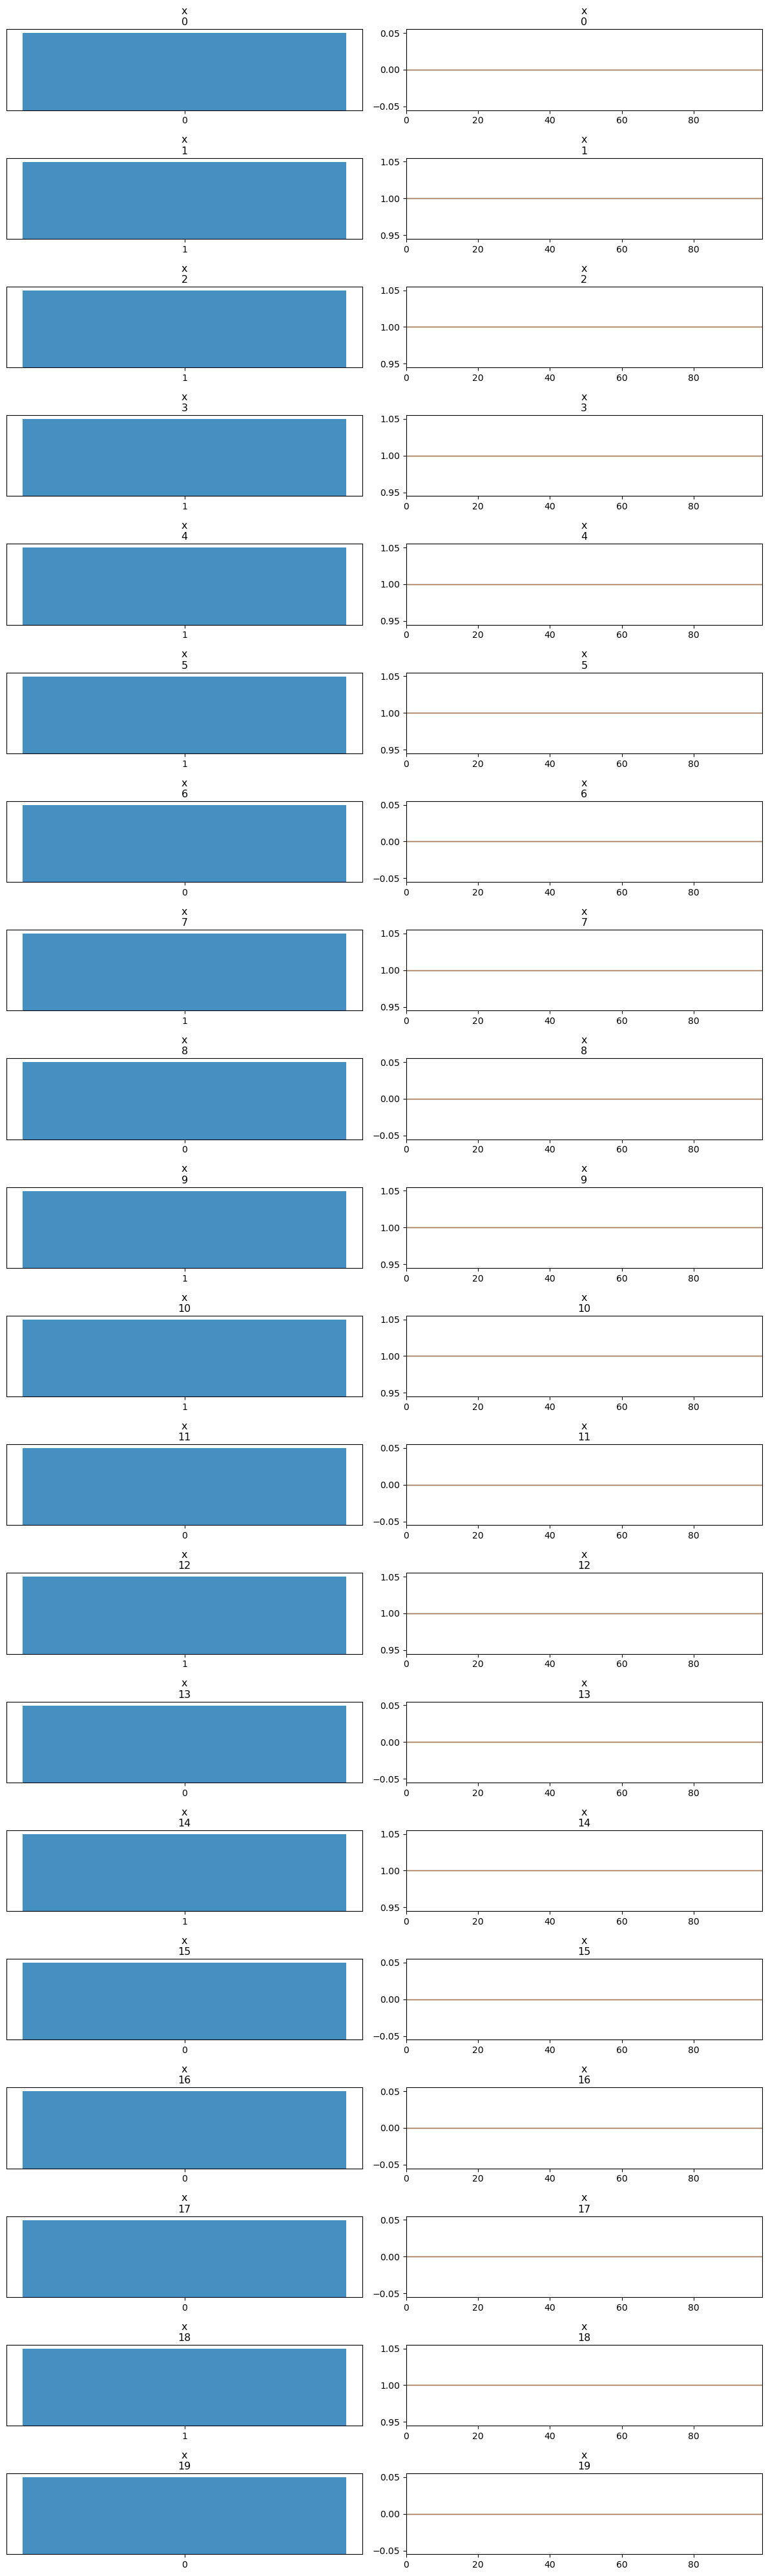

In [41]:
pm.plot_trace(trace, var_names=['x'], compact=False);